# Deep learning the collisional cross sections of the peptide universe from a million experimental values

Florian Meier, Niklas D. Köhler, Andreas-David Brunner, Jean-Marc H. Wanka, Eugenia Voytik, Maximilian T. Strauss, Fabian J. Theis, Matthias Mann

Pre-print: https://doi.org/10.1101/2020.05.19.102285  
Publication: pending

revised 09/2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from numba import njit, prange
import time

from scipy import stats
import scipy.cluster.hierarchy as shc
import scipy.spatial.distance as ssd

In [2]:
@njit
def mean_dist_pairwise(matrix, shape):
    dist = np.zeros((shape,shape))
    
    for i in prange(shape):
        for j in prange(shape):
            dist[j,i] = np.nanmean(matrix[:,i] - matrix[:,j])
    
    return dist  

#### Import raw data from MaxQuant output

In [3]:
# Load evidence.txt files from folder
filenames = glob.glob("data/evidence*.txt")
evidences = [pd.read_csv(filename, sep='\t', engine='python', header=0) for filename in filenames]

# Combine all evidences in one dataframe
evidence_all = pd.concat(evidences, sort=False, ignore_index=True)

# Clean up 
del evidences

evidence_all.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,Missed cleavages (Trypsin/P),Missed cleavages (LysN),Missed cleavages (LysC/P),Unnamed: 0,1/K0
0,AAAAELLLNLLFFEK,15,Unmodified,_AAAAELLLNLLFFEK_,NaN,NaN,0,0,0.0,G5EG62,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAELLLNLLFFEK,15,Unmodified,_AAAAELLLNLLFFEK_,NaN,NaN,0,0,0.0,G5EG62,...,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAIIDSTTETNKGDDYR,19,Unmodified,_AAAAIIDSTTETNKGDDYR_,NaN,NaN,0,0,1.0,G5EC97,...,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAANLNYIR,10,Unmodified,_AAAANLNYIR_,NaN,NaN,0,0,0.0,P53588,...,2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAPTISQSISTLTSGMR,19,Oxidation (M),_AAAAPTISQSISTLTSGM(ox)R_,AAAAPTISQSISTLTSGM(1)R,AAAAPTISQSISTLTSGM(70.6)R,0,1,0.0,O02109,...,3,4,4,NaN,2035,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop reverse hits
# Drop features with no intensity value
# Drop charge 1 features

evidence_all = evidence_all.loc[(evidence_all['Reverse'] != '+') & \
                                (evidence_all['Intensity'] > 0) & \
                                (evidence_all['Charge'] != 1)]
len(evidence_all)

2786717

In [5]:
# Keep only one evidence per raw file
# Select feature with maximum intensity

selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'CCS', 'Experiment', 
             'id', 'Intensity', 'Score', 'Length', 'Raw file']
evidence_agg = evidence_all.loc[evidence_all.groupby(
    ['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()][selection]

evidence_pivot_long = evidence_agg.pivot_table(index = ['Modified sequence', 'Charge'], 
                                               columns = 'Raw file', 
                                               values = 'CCS')
del evidence_agg 

evidence_pivot_long = evidence_pivot_long.astype(np.float32)

len(evidence_pivot_long)

718917

In [6]:
# Filter peptides with only one occurence to speed up and save memory (747 runs - 1)

evidence_pivot = evidence_pivot_long.loc[evidence_pivot_long.isnull().sum(axis=1) < (len(set(evidence_all['Raw file'])) - 1)]
evidence_pivot = evidence_pivot.astype(np.float32)

len(evidence_pivot_long), len(evidence_pivot)

(718917, 374862)

#### Align CCS values

In [7]:
# calculate pair-wise distances

start = time.time()
evidence_distance = pd.DataFrame(mean_dist_pairwise(np.array(evidence_pivot), evidence_pivot.shape[1]))
end = time.time()

print((end - start)/60)

6.063884325822195


In [8]:
evidence_distance.shape

(747, 747)

In [9]:
# Fill NA distances with arbitrary large number
evidence_distance_cluster = evidence_distance.fillna(3*evidence_distance.max().max())
evidence_distance_cluster.min().min(), evidence_distance_cluster.max().max()

(-180.5926513671875, 541.7779541015625)

In [10]:
# save result matrix
evidence_distance.to_csv('output/evidence_distance_float32.csv', index=False)
print('File exported.')

File exported.


In [11]:
# load result matrix
evidence_distance = pd.read_csv('output/evidence_distance_float32.csv')

In [12]:
dist_matrix = ssd.squareform(evidence_distance_cluster, checks=False)
dist_matrix

array([ 1.21554856,  1.02286336,  1.52692547, ..., -0.21146111,
       -0.43880397, -0.89470349])

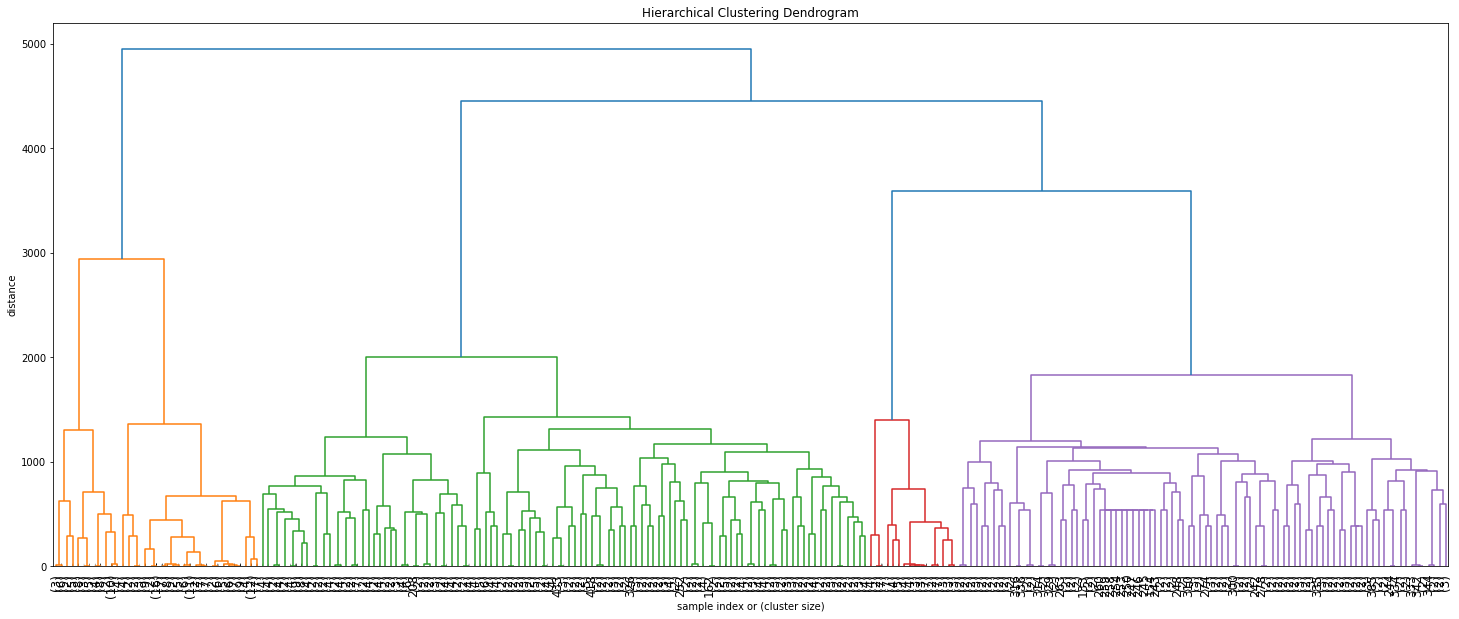

In [13]:
# Perform hierarchical clustering to sort runs by distance

Z = shc.linkage(abs(dist_matrix), 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')

shc.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=250,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

In [14]:
nruns = len(evidence_pivot_long.columns) 

In [15]:
col = nruns
nancount = 0

for cluster in Z:
    # loop through clusters and merge them pairwise      
    
    # align first
    delta = np.nanmean(evidence_pivot_long.iloc[:, int(cluster[1])] - evidence_pivot_long.iloc[:, int(cluster[0])])   
    
    if(~np.isnan(delta)):
        # Merge neighboring runs 
        # Calculate mean

        evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])] - 0.5*delta, 
                                               evidence_pivot_long.iloc[:, int(cluster[0])] + 0.5*delta], axis = 0)
    else:
        # NaN difference in a cluster to be merged   
        # Merge runs but keep external calibration
        
        evidence_pivot_long[col] = np.nanmean([evidence_pivot_long.iloc[:, int(cluster[1])], 
                                               evidence_pivot_long.iloc[:, int(cluster[0])]], axis = 0)

        
    col += 1
    
print('Clusters merged.')

C:\Users\voytik\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\voytik\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\voytik\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


Clusters merged.


In [16]:
# Store experimental values in separate dataframe
evidence_pivot_tmp = evidence_pivot_long.copy()
evidence_pivot_long = evidence_pivot_long.iloc[:, 0:nruns]

len(evidence_pivot_tmp.columns), len(evidence_pivot_long.columns)

(1493, 747)

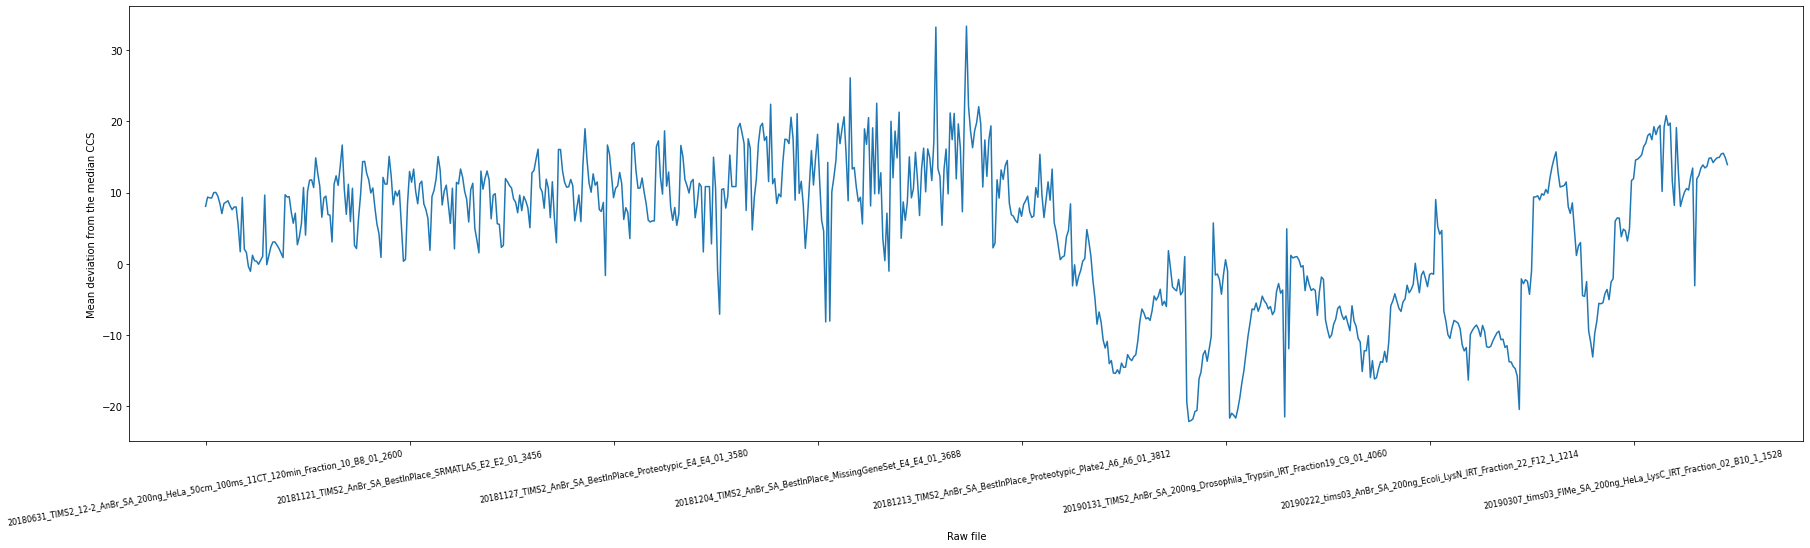

In [17]:
# Calculate deviation from mean to use as correction factors

evidence_pivot_deviation = evidence_pivot_long.subtract(evidence_pivot_tmp.iloc[:, -1], axis = 0)
evidence_pivot_deviation.mean(axis = 0, skipna = True).plot(figsize = (30,8))

plt.xlabel('Raw file')
plt.ylabel('Mean deviation from the median CCS')
plt.xticks(size=8, rotation=10);

In [18]:
# Subtract run correction factor from each peptide CCS value in each run
evidence_pivot_aligned = evidence_pivot_long.subtract(evidence_pivot_deviation.mean(axis = 0, skipna = True), axis = 1)

In [19]:
# Export aligned dataset
evidence_pivot_aligned.to_csv('output/evidence_pivot_aligned.csv', index=False)
print('Aligned pivot dataset exported.')

Aligned pivot dataset exported.


### Whole-proteome digests

In [20]:
#evidence_pivot_aligned = pd.read_csv('output/evidence_pivot_aligned.csv')

In [21]:
# Exclude Proteome Tools data
proteometools = set(evidence_all.loc[evidence_all['Experiment'].isin(
    ['Proteotypic', 'SRMATLAS', 'MissingGeneSet'])]['Raw file'])
evidence_pivot_aligned_endo = evidence_pivot_aligned.drop(proteometools, axis = 1)

len(evidence_pivot_aligned.columns), len(evidence_pivot_aligned_endo.columns)

(747, 360)

In [22]:
# Calculate mean CCS value from aligned data

evidence_short_aligned = evidence_pivot_aligned_endo.drop(columns = evidence_pivot_aligned_endo.columns.tolist())
evidence_short_aligned['CCS'] = evidence_pivot_aligned_endo.mean(axis = 1, skipna = True)
evidence_short_aligned.reset_index(inplace = True)
evidence_short_aligned = evidence_short_aligned.dropna()

In [23]:
# Select evidences

group = ['CElegans_Tryp',
 'Drosophila_LysC',
 'Drosophila_LysN',
 'Drosophila_Trp',
 'Ecoli_LysC',
 'Ecoli_LysN',
 'Ecoli_trypsin',
 'HeLa_LysC',
 'HeLa_LysN',
 'HeLa_Trp_2',
 'HeLa_Trypsin_1',
 'Yeast_LysC',
 'Yeast_LysN',
 'Yeast_Trypsin']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
len(evidence_tmp)

2465262

In [24]:
# Select evidence columns of interest
selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'Experiment', 'id', 
             'Intensity', 'Score', 'Length', 'Retention time']
evidence_unique = evidence_tmp.loc[evidence_tmp.groupby(['Modified sequence', 'Charge'])['Intensity'].idxmax()][selection]

In [25]:
len(evidence_short_aligned['CCS']), len(evidence_unique)

(559979, 559979)

In [26]:
evidence_unique['CCS'] = evidence_short_aligned['CCS'].values
evidence_unique.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS
1095336,_(ac)AAAAAAAAAAGAAGGR_,AAAAAAAAAAGAAGGR,2,1239.63200,620.823275,HeLa_Trp_2,9,149810.0,162.800,16,70.140,409.092438
1447561,_(ac)AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR_,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,3,3144.55482,1049.192220,HeLa_Trypsin_1,124,194000.0,71.438,39,3947.700,772.098022
1095353,_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,AAAAAAAGDSDSWDADAFSVEDPVRK,2,2634.18340,1318.098980,HeLa_Trp_2,26,6416400.0,111.750,26,94.079,573.213257
1095357,_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,AAAAAAAGDSDSWDADAFSVEDPVRK,3,2634.18340,879.068411,HeLa_Trp_2,30,5400600.0,42.218,26,94.841,635.000610
1095350,_(ac)AAAAAAAGDSDSWDADAFSVEDPVR_,AAAAAAAGDSDSWDADAFSVEDPVR,2,2506.08844,1254.051500,HeLa_Trp_2,23,245720.0,135.890,25,104.620,547.559082


In [27]:
# Export aligned dataset for deep learning
evidence_unique.to_csv('output/evidence_aligned.csv', index=False)
print('Aligned dataset exported.')

Aligned dataset exported.


### ProteomeTools

In [28]:
# Proteome Tools data
proteometools = set(evidence_all.loc[~evidence_all['Experiment'].isin(
    ['Proteotypic', 'SRMATLAS', 'MissingGeneSet'])]['Raw file'])
evidence_pivot_aligned_PT = evidence_pivot_aligned.drop(proteometools, axis = 1)

len(evidence_pivot_aligned.columns), len(evidence_pivot_aligned_PT.columns)

(747, 387)

In [29]:
# Calculate mean CCS value from aligned data

evidence_short_aligned_PT = evidence_pivot_aligned_PT.drop(columns = evidence_pivot_aligned_PT.columns.tolist())
evidence_short_aligned_PT['CCS'] = evidence_pivot_aligned_PT.mean(axis = 1, skipna = True)
evidence_short_aligned_PT.reset_index(inplace = True)
evidence_short_aligned_PT = evidence_short_aligned_PT.dropna()

In [30]:
# Select evidences

group = ['Proteotypic', 'SRMATLAS', 'MissingGeneSet']    

evidence_tmp = evidence_all.loc[evidence_all['Experiment'].isin(group)]
len(evidence_tmp)

321455

In [31]:
# Select evidence columns of interest
selection = ['Modified sequence', 'Sequence', 'Charge', 'Mass', 'm/z', 'Experiment', 
             'id', 'Intensity', 'Score', 'Length', 'Retention time']
evidence_unique_PT = evidence_tmp.loc[evidence_tmp.groupby(['Modified sequence', 'Charge'])['Intensity'].idxmax()][selection]

In [32]:
len(evidence_short_aligned_PT['CCS']), len(evidence_unique_PT)

(213852, 213852)

In [33]:
evidence_unique_PT['CCS'] = evidence_short_aligned_PT['CCS'].values
evidence_unique_PT.head()

,Modified sequence,Sequence,Charge,Mass,m/z,Experiment,id,Intensity,Score,Length,Retention time,CCS
2127089,_(ac)AAAAAAAAEQQSSNGPVKK_,AAAAAAAAEQQSSNGPVKK,2,1810.91734,906.465946,Proteotypic,11,21349.0,89.382,19,19.645,481.229279
2127135,_(ac)AAAAAATAAAAASIR_,AAAAAATAAAAASIR,2,1298.69426,650.354408,Proteotypic,57,29524.0,112.930,15,37.452,417.830170
2127143,_(ac)AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR_,AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR,3,2948.45629,983.826039,Proteotypic,65,27953.0,52.195,35,41.412,782.935242
2127146,_(ac)AAAAAETPEVLRECGCK_,AAAAAETPEVLRECGCK,2,1873.86623,937.940392,Proteotypic,68,27993.0,75.012,17,26.756,480.424042
2127150,_(ac)AAAAAGLGGGGAGPGPEAGDFLAR_,AAAAAGLGGGGAGPGPEAGDFLAR,2,2052.00247,1027.008510,Proteotypic,72,64770.0,123.920,24,39.708,515.897827


In [34]:
# Export aligned dataset for deep learning
evidence_unique_PT.to_csv('output/evidence_aligned_PT.csv', index=False)
print('Aligned dataset exported.')

Aligned dataset exported.


### Comparison whole-proteome measurements vs. ProteomeTools (experimental)

In [35]:
evidence_PT = evidence_pivot_aligned_PT.drop(columns = evidence_pivot_aligned_PT.columns.tolist())
evidence_PT['CCS'] = evidence_pivot_aligned_PT.mean(axis = 1, skipna = True)
evidence_PT.reset_index(inplace = True)

In [36]:
evidence_endo = evidence_pivot_aligned_endo.drop(columns = evidence_pivot_aligned_endo.columns.tolist())
evidence_endo['CCS'] = evidence_pivot_aligned_endo.mean(axis = 1, skipna = True)
evidence_endo.reset_index(inplace = True)

In [37]:
len(evidence_PT), len(evidence_endo)

(718917, 718917)

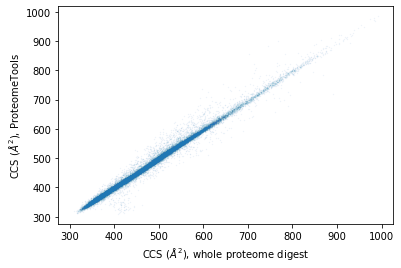

In [38]:
plt.scatter(evidence_endo['CCS'], evidence_PT['CCS'], s = 0.1, alpha = 0.1)
plt.xlabel('CCS ($\AA^2$), whole proteome digest')
plt.ylabel('CCS ($\AA^2$), ProteomeTools');

In [41]:
mask = ~np.logical_or(np.isnan(evidence_endo['CCS']), np.isnan(evidence_PT['CCS']))  
pcorr = stats.pearsonr(evidence_endo['CCS'][mask], evidence_PT['CCS'][mask])[0]

print('Pearson correlation: {:1.3f}'.format(pcorr))
print('n = {0}'.format(mask.sum()))

Pearson correlation: 0.995
n = 54914


In [42]:
print('Median absolute deviation = {:1.1f}%'.format(np.abs((evidence_endo['CCS'] - evidence_PT['CCS']) /
                                                           evidence_endo['CCS'] * 100).median()))

Median absolute deviation = 0.6%
